In [1]:
from autograd import grad

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import multivariate_normal, truncnorm
import scipy.stats as stats
from scipy.stats import chi2, norm, invgamma

import seaborn as sns
import statsmodels.api as sm

from tqdm import tqdm

# Markov Chain Monte-Carlo Sampling

We implement MCMC methods to sample from a posterior distribution. Let's start by having a look at the data. </br></br>  $(y_1,y_2,\dots,y_n)$ are gene expression measurements for two genes on $n$ samples, where $y_k = (y_{k1},y_{k2})$
represent the two gene expressions for sample $k$. There are four different groups of samples: each group-1
sample contains cells of cell type A (say adipose cells), each group 2 sample contains cells of cell type B (say
blood vessel cells), each group 3 sample contain cells from tissue type C which is a 50%-50% mixture of type
A and type B cells, each group 4 sample contain cells from tissue type D which is also a mixture of type A
and type B cells but the mixing proportion $\tau$ is unknown. The group labels for all samples are known and
are denoted by $(t_1,t_2,...,t_n)$. For example, $t_9 = 2$ if sample 9 is in group 2.

We assume that for each gene the mean expression (but not the variance) depends on the cell type, and that, given the cell type, the expressions of different genes are independently normally distributed. Specifically, for a given sample $k$,
- $Y_1 \sim N\left(\mu, \sigma^2 I\right)$ if sample $k$ is from group 1 ($\mu$ is a 2-vector, $I$ is the 2 by 2 identity matrix)
- $Y_2 \sim N\left(\gamma, \sigma^2 I\right)$ if sample $k$ is from group 2
- $Y_3 \sim N\left(0.5 \mu+0.5 \gamma, \sigma^2 I\right)$ if sample $k$ is from group 3
- $Y_4 \sim N\left(\tau \mu+(1-\tau) \gamma, \sigma^2 I\right)$ if sample $k$ is from group 4 </br>

This model has a 6-dimensional parameter $\theta=\left(\sigma^2, \tau, \mu_1, \mu_2, \gamma_1, \gamma_2\right)$.

Let's start by reading the data and plotting it to get an idea of what we're working with.

In [2]:
data = pd.read_csv("data.csv")
data = data.drop('Unnamed: 0', axis=1)

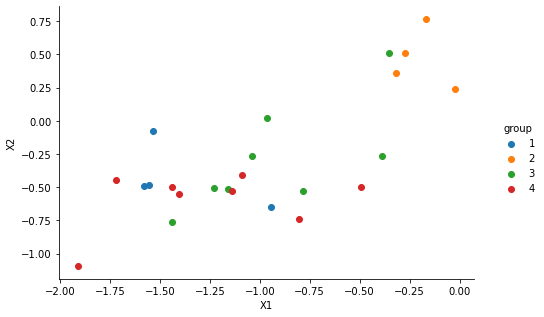

In [3]:
groups = [1,2,3,4]
fg = sns.FacetGrid(data, hue='group', hue_order=groups, aspect=1.61)
fg.map(plt.scatter, 'X1', 'X2').add_legend();
fig = plt.gcf();
fig.set_size_inches((8,5));

Before implementing any MCMC method, we need the posterior distribution (up to a constant factor) which we will then sample from. The posterior distribution will be proportional to the likelihood times the prior. The priors are given to us as follows: 

1. Prior for $\tau$ will be uniform on [0,1]
2. Prior for $\mu, \gamma$ will be the (improper) uniform prior on the real line
3. Prior for $\sigma^2$ will be proportional to $\frac{1}{\sigma^2}$

The likelihood is as follows:
$$
\begin{align}
\mathcal{L}(y|\theta) &= \prod_{k=1}^{n} f_{Y_1}(y_k)^{I_1}f_{Y_2}(y_k)^{I_2}f_{Y_3}(y_k)^{I_3}f_{Y_4}(y_k)^{I_4}
\end{align}
$$
where $f_{Y_i}$ are the PDFs of samples coming from group $i$ and $I_i$ are the indicators representing if sample $k$ is in group $i$. For example,
$$
\begin{align}
f_{Y_1}(y_k) = (2 \pi)^{-1} \operatorname{det}(\sigma^2 I)^{-\frac{1}{2}} \exp \left(-\frac{1}{2}(y_k-\mu)^{T} (\sigma^2 I)^{-1}(y_k-\mu)\right)
\end{align}
$$
The following function computes this likelihood.

In [4]:
def calc_likelihood(theta, y=data):
    
    sig_sq, tau, mu1, mu2, gam1, gam2 = theta
    y1, y2, group = y['X1'], y['X2'], y['group']
    num_obs = len(group)
    likelihood = 1
    
    for i in range(num_obs):
        
        if group[i] == 1:
            var = multivariate_normal(mean=[mu1, mu2], cov=[[sig_sq,0], [0,sig_sq]])
            likelihood *= var.pdf([y1[i], y2[i]])
            
        if group[i] == 2:
            var = multivariate_normal(mean=[gam1, gam2], cov=[[sig_sq,0], [0,sig_sq]])
            likelihood *= var.pdf([y1[i], y2[i]])
        
        if group[i] == 3:
            mean = [0.5*mu1+0.5*gam1, 0.5*mu2+0.5*gam2]
            var = multivariate_normal(mean=mean, cov=[[sig_sq,0], [0,sig_sq]])
            likelihood *= var.pdf([y1[i], y2[i]])
            
        if group[i] == 4:
            mean = [tau*mu1+(1-tau)*gam1, tau*mu2+(1-tau)*gam2]
            var = multivariate_normal(mean=mean, cov=[[sig_sq,0], [0,sig_sq]])
            likelihood *= var.pdf([y1[i], y2[i]])
    
    return likelihood

We can now write a function to compute the posterior density (up to a constant).

In [5]:
def calc_posterior(theta, y=data):
    
    prior = 1.0/theta[0]
    likelihood = calc_likelihood(theta, y)
    posterior = prior*likelihood
    
    return posterior

To evaluate the performance of our MCMC sampling algorithms, we write a central function to which we feed the genereated samples and it gives us several metrics evaluated on those samples. The following are these auxillary functions to check the estimates once they've been generated by any of the MCMC algorithms. 

The first function gives us the values of a few metrics empirically calculated using the data. These can be considered as the MLEs for the various parameters. We use these parameters to find mea statistics for the 4 groups.

The second function takes in the samples generated from any sampling algorithm and plots histograms, calculates mean statistics and also gives us the auto-correlation within the samples (an important statistic since it tells us the Markov nature of the MCMC methods).

In [6]:
def actual_estimates(y=data):
    
    np.set_printoptions(precision=3)
    
    y1, y2, group = y['X1'], y['X2'], y['group']
    num_obs = len(group)
    mu1, mu2, gam1, gam2, g3_1, g3_2, g4_1, g4_2 = 0, 0, 0, 0, 0, 0, 0, 0 # g4 is the mean of group 4
    c1, c2, c3, c4 = 0, 0, 0, 0 # counters
    
    for i in range(num_obs):
        
        if group[i] == 1:
            mu1 += y1[i]
            mu2 += y2[i]
            c1 += 1
            
        if group[i] == 2:
            gam1 += y1[i]
            gam2 += y2[i]
            c2 += 1
            
        if group[i] == 3:
            g3_1 += y1[i]
            g3_2 += y2[i]
            c3 += 1
        
        if group[i] == 4:
            g4_1 += y1[i]
            g4_2 += y2[i]
            c4 += 1
    
    print("\nFor reference:")
    print("The actual mean of group 1 is ({}, {})".format(round(mu1/c1, 3), round(mu2/c1, 3)))
    print("The actual mean of group 2 is ({}, {})".format(round(gam1/c2, 3), round(gam2/c2, 3)))
    print("The actual mean of group 3 is ({}, {})".format(round(g3_1/c3, 3), round(g3_2/c3, 3)))
    print("The actual mean of group 4 is ({}, {})".format(round(g4_1/c4, 3), round(g4_2/c4, 3)))

In [7]:
def check_estimates(samples, y=data):
    
    parameters = ["sigma_sq", "tau", "mu_1", "mu_2", "gamma_1", "gamma_2"]
    means = {}
    
    for i in range(6):
        means[parameters[i]] = np.mean([sample[i] for sample in samples])
    
    for i in range(6):
        print("The mean estimate for {} is {}".format(parameters[i], round(means[parameters[i]], 3)))
        
    means_g3_1 = 0.5*means["mu_1"]+0.5*means["gamma_1"]
    means_g3_2 = 0.5*means["mu_2"]+0.5*means["gamma_2"]
    means_g4_1 = means["tau"]*means["mu_1"]+(1-means["tau"])*means["gamma_1"]
    means_g4_2 = means["tau"]*means["mu_2"]+(1-means["tau"])*means["gamma_2"]
    
    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(2, 3)

    f_ax1 = fig.add_subplot(gs[0, 0])
    f_ax1.hist([sample[0] for sample in samples], bins=50, facecolor = '#2ab0ff', \
               edgecolor='#169acf', linewidth=0.5, density=True)
    f_ax1.set_title('sigma_sq');
    
    f_ax2 = fig.add_subplot(gs[0, 1])
    f_ax2.hist([sample[2] for sample in samples], bins=50, facecolor = '#2ab0ff', \
               edgecolor='#169acf', linewidth=0.5, density=True)
    f_ax2.set_title('mu_1');
    
    f_ax3 = fig.add_subplot(gs[1, 0])
    f_ax3.hist([sample[1] for sample in samples], bins=50, facecolor = '#2ab0ff', \
               edgecolor='#169acf', linewidth=0.5, density=True)
    f_ax3.set_title('tau');
    
    f_ax4 = fig.add_subplot(gs[1, 1])
    f_ax4.hist([sample[3] for sample in samples], bins=50, facecolor = '#2ab0ff', \
               edgecolor='#169acf', linewidth=0.5, density=True)
    f_ax4.set_title('mu_2');
    
    f_ax3 = fig.add_subplot(gs[0, 2])
    f_ax3.hist([sample[4] for sample in samples], bins=50, facecolor = '#2ab0ff', \
               edgecolor='#169acf', linewidth=0.5, density=True)
    f_ax3.set_title('gamma_1');
    
    f_ax3 = fig.add_subplot(gs[1, 2])
    f_ax3.hist([sample[5] for sample in samples], bins=50, facecolor = '#2ab0ff', \
               edgecolor='#169acf', linewidth=0.5, density=True)
    f_ax3.set_title('gamma_2');
    
    img = plt.gcf()
    img.set_size_inches((14,7));
    plt.show();
    
    print("\nUsing these estimates, we get the following:")
    print("The mean of group 1 is ({}, {})".format(round(means["mu_1"], 3), round(means["mu_2"], 3)))
    print("The mean of group 2 is ({}, {})".format(round(means["gamma_1"], 3), round(means["gamma_2"], 3)))
    print("The mean of group 3 is ({}, {})".format(round(means_g3_1, 3), round(means_g3_2, 3)))
    print("The mean of group 4 is ({}, {})".format(round(means_g4_1, 3), round(means_g4_2, 3)))
    
    actual_estimates()
    
    print("\nWe also look at the correlation at lag 1 to see the Markov nature of the process.")
    for i in range(6):
        print("The Pearson correlation for {} is ".format(parameters[i]), end='')
        print(round(stats.pearsonr([s[i] for s in samples][1:], [s[i] for s in samples][:-1])[0], 3))

Now we're ready to implement MCMC methods. We start with the most famous MCMC algorithm - Metropolis Hastings.

## 1. Metropolis-Hastings 

In MH, we start with an initial guess and generate samples using the previous sample (Markov property). This Markov Chain eventually converges to a stationary distribution equal to the distribution we want to sample from after a burn-in period. The samples are accepted or rejected using the MH ratio. For each of the six parameters, we use the transition kernel $q(x_{t+1}|x_t) = N(x_t, \sigma_w^2)$. This means our next draw for any parameter is a normal distribution centered at the previous draw. Note that $\sigma_w^2$ is essentially the jump size for any parameter. We can experiment with different values of $\sigma_w^2$ to find the best jump size. Another thing to note is that since we are using a normal kernel, it is symmetric and hence this is simply the Metrolopolis algorithm. </br>

The initial guesses for the parameters are based on the mean values of the priors and the inital guess for $\sigma^2$ is 1. One way of constraining the values of $\sigma^2$ and $\tau$ is by redefining them to their initial guess every time they go out of bound. We do that here. We can also use a truncated normal to constraint the values of $\sigma^2$ and $\tau$.

In [8]:
np.random.seed(2)
def metropolis(initial, num_iters, sigw): # takes the stddev, not the variance
    
    samples = [initial]
    num_accept = 0
    
    for _ in tqdm(range(num_iters), desc = 'Progress Bar'):
        
        candidate = [parameter + np.random.normal(0, sigw) for parameter in samples[-1]]
        if candidate[0]<=0: # constraining the value for sig_sq
            candidate[0] = 1
        if candidate[1]<0 or candidate[1]>1: # constraining the value for tau
            candidate[1] = 0.5

        accept_prob = min(1, calc_posterior(candidate)/calc_posterior(samples[-1]))
        
        if np.random.random() < accept_prob:
            samples.append(candidate)
            num_accept += 1
        else:
            samples.append(samples[-1])
            
    return samples, num_accept/num_iters

Let's run the Metropolis algorithm on our data and check the estimates.

In [9]:
np.random.seed(2)
num_iters = int(1e5)
burn_in = num_iters//100
initial = [1, 0.5, 0, 0, 0, 0]
samples_mh, efficiency = metropolis(initial, num_iters, sigw=0.08)
samples_mh = samples_mh[burn_in:]
print("The efficiency of the MH run is {}".format(efficiency))

Progress Bar: 100%|████████████████████| 100000/100000 [08:56<00:00, 186.47it/s]

The efficiency of the MH run is 0.18969


The mean estimate for sigma_sq is 0.128
The mean estimate for tau is 0.856
The mean estimate for mu_1 is -1.433
The mean estimate for mu_2 is -0.662
The mean estimate for gamma_1 is -0.275
The mean estimate for gamma_2 is 0.319


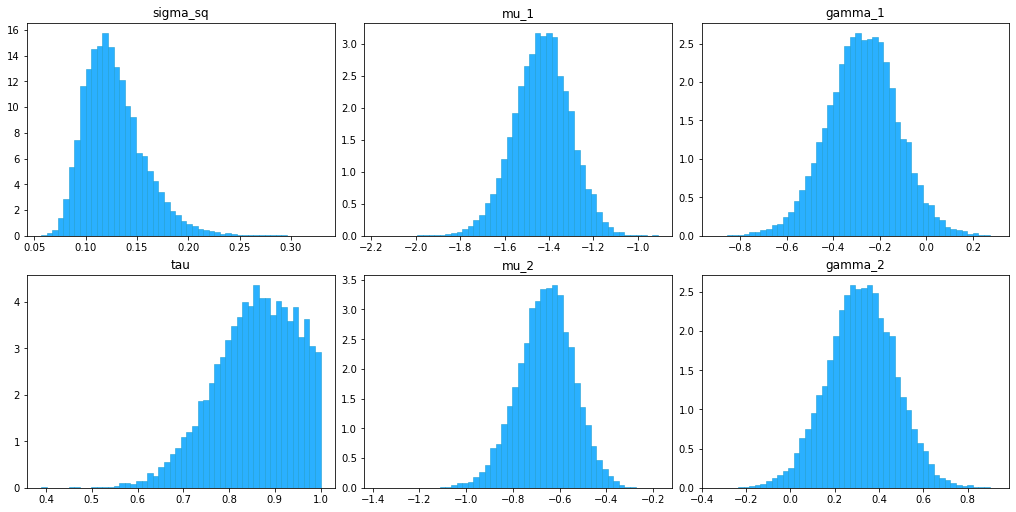


Using these estimates, we get the following:
The mean of group 1 is (-1.433, -0.662)
The mean of group 2 is (-0.275, 0.319)
The mean of group 3 is (-0.854, -0.172)
The mean of group 4 is (-1.267, -0.521)

For reference:
The actual mean of group 1 is (-1.403, -0.423)
The actual mean of group 2 is (-0.196, 0.471)
The actual mean of group 3 is (-0.919, -0.289)
The actual mean of group 4 is (-1.25, -0.594)

We also look at the correlation at lag 1 to see the Markov nature of the process.
The Pearson correlation for sigma_sq is 0.827
The Pearson correlation for tau is 0.947
The Pearson correlation for mu_1 is 0.969
The Pearson correlation for mu_2 is 0.965
The Pearson correlation for gamma_1 is 0.977
The Pearson correlation for gamma_2 is 0.977


In [10]:
check_estimates(samples_mh, data)

Notice that our estimates using the MH algorithm are fairly close to the actual values (means calculated from the data), but there is still room for improvement. This might be indicative of the poor performance of MH in higher dimensions.

Another thing to note is that the correlation values for each of the parameter estimates are pretty high, showing the Markov property of the process.

### Hyperparameter Tuning
Now we change the values of our jump parameter to find the best jump. We use $\mu_1$ and $\gamma_2$ as two random parameters to check the accuracy of our estimation.

Progress Bar: 100%|██████████████████████| 10000/10000 [00:53<00:00, 186.00it/s]


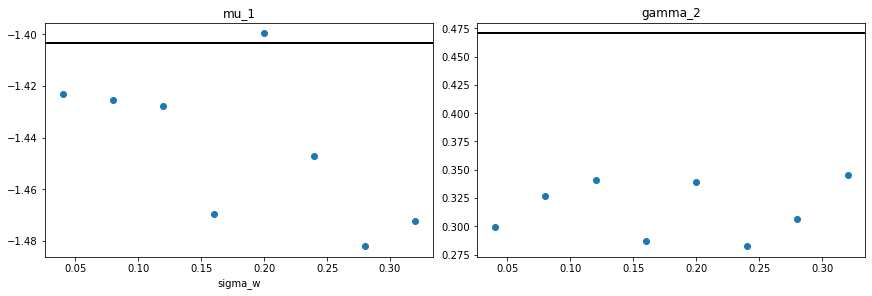

In [11]:
np.random.seed(2)
values = {"mu_1":[], "gamma_2":[]}

for sigw in np.arange(0.04, 0.33, 0.04):
    means = []
    samples_mh, _ = metropolis(initial, num_iters=int(1e4), sigw=sigw)
    values["mu_1"].append(np.mean([sample[2] for sample in samples_mh]))
    values["gamma_2"].append(np.mean([sample[5] for sample in samples_mh]))
    
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(1, 2)

f_ax1 = fig.add_subplot(gs[0, 0])
f_ax1.scatter(x=np.arange(0.04, 0.33, 0.04), y=values["mu_1"])
f_ax1.axhline(-1.4033, color ='0', lw = 2) # actual value
f_ax1.set_xlabel('sigma_w');
f_ax1.set_title('mu_1');

f_ax2 = fig.add_subplot(gs[0, 1])
f_ax2.scatter(x=np.arange(0.04, 0.33, 0.04), y=values["gamma_2"])
f_ax2.axhline(0.4705, color ='0', lw = 2) # actual value
f_ax1.set_xlabel('sigma_w');
f_ax2.set_title('gamma_2');

img = plt.gcf()
img.set_size_inches((12,4));
plt.show();

The black line in the plots above show the actual value of the mean using the data (empirical mean). We can see here that the MH algorithm with our initial conditions, while always close to the true value, can still be improved since it is likely to get stuck at a point. Another interesting observation is the systematic tendency for underestimating the parameter values. This can again be explained by the nature of the algorithm: once it's found an accepted sample, it doesn't accept another sample point till the density at that sample point is relatively higher, so the samples tend to be similar.
</br>

Next, we move to Hamiltonian Monte Carlo.

## 2. Hamiltonian Monte-Carlo

In HMC, we usa an analogy from statistical mechanics where we have a particle whose energy (the Hamiltonian $H$) is conserved. The total energy $H$ is defined as the sum of two components $U(q)$ and $K(p)$ where $U$ is the potential energy in terms of the parameters $q$ and we introduce the kinetic energy term $K$ in terms of the momentum $p$.
$$
H(q, p) = U(q) + K(p)
$$
The probability of the particle having energy $H$ turns out to be proportional to $e^{-\frac{H}{T}}$ where $T$ is the temperature which is chosen to be $1$ when we want to sample straight from the posterior and not a skewed version of it.

It is convenient to define the posterior density $\pi(q)$ (which is our target density) as being proportional to $e^{-U(q)}$. Hence $U(q) = -\log \pi(q)$. Let's define functions for the same. For the four different groups, the negative log density (NLD) is different. Separating them out vastly saves computation time. For example, for group 1, the posterior density is the prior times the likelihood $\mathcal{L}$ defined above. However, only $I_1$ is $1$ while the other indicators are $0$. So taking the log and using the indicators, we get that the NLD is
$$
\begin{align}
NLD_1 &= \log\sigma^2 + \sum[\log\sigma^2 + \frac{1}{2}\left((y_k-\mu)^{T} (\sigma^2 I)^{-1}(y_k-\mu)\right)]\\
&= \log\sigma^2 + \sum[\log\sigma^2 + \frac{1}{2}(\frac{{(y_{k1}-\mu_1)}^2}{\sigma^2}+\frac{{(y_{k2}-\mu_2)}^2}{\sigma^2})]
\end{align}
$$
We can calculate the other NLDs similarly by changing the mean.

In [8]:
def nld_1(sig_sq, tau, mu1, mu2, gam1, gam2, y): # negative log density for group 1
    
    term1 = 2*np.log(sig_sq)
    term2 = 0
    mu = np.array([mu1, mu2])
    cov_inv = np.array([[1/sig_sq,0], [0,1/sig_sq]])
    
    for i in range(len(y[0])):
        
        y1, y2 = y[0][i], y[1][i]
        term2 += np.log(sig_sq) + 0.5*((y1-mu1)**2/sig_sq + (y2-mu2)**2/sig_sq)
        
    return term1 + term2

def nld_2(sig_sq, tau, mu1, mu2, gam1, gam2, y): # negative log density for group 2
    
    term1 = 2*np.log(sig_sq)
    term2 = 0
    mu = np.array([gam1, gam2])
    cov_inv = np.array([[1/sig_sq,0], [0,1/sig_sq]])
    
    for i in range(len(y[0])):
        
        y1, y2 = y[0][i], y[1][i]
        term2 += np.log(sig_sq) + 0.5*((y1-mu1)**2/sig_sq + (y2-mu2)**2/sig_sq)
        
    return term1 + term2

def nld_3(sig_sq, tau, mu1, mu2, gam1, gam2, y): # negative log density for group 3
    
    term1 = 2*np.log(sig_sq)
    term2 = 0
    mu = np.array([0.5*mu1+0.5*gam1, 0.5*mu2+0.5*gam2])
    cov_inv = np.array([[1/sig_sq,0], [0,1/sig_sq]])
    
    for i in range(len(y[0])):
        
        y1, y2 = y[0][i], y[1][i]
        term2 += np.log(sig_sq) + 0.5*((y1-mu1)**2/sig_sq + (y2-mu2)**2/sig_sq)
        
    return term1 + term2

def nld_4(sig_sq, tau, mu1, mu2, gam1, gam2, y): # negative log density for group 4
    
    term1 = 2*np.log(sig_sq)
    term2 = 0
    mu = np.array([tau*mu1+(1-tau)*gam1, tau*mu2+(1-tau)*gam2])
    print(mu)
    cov_inv = np.array([[1/sig_sq,0], [0,1/sig_sq]])
    
    for i in range(len(y[0])):
        
        y1, y2 = y[0][i], y[1][i]
        term2 += np.log(sig_sq) + 0.5*((y1-mu1)**2/sig_sq + (y2-mu2)**2/sig_sq)
        
    return term1 + term2

From physics, we know that $K(p) = \frac{p^2}{2m}$ where $m$ is the mass. Putting it together, the probability of the particle having energy $H$ is porportional to $\pi(q)e^{-\frac{p^2}{2m}}$.

Since we model the momentum and position as being independent terms, the second term in the above proportionality must represent the distribution of the momentum $p$ which clearly follows a standard normal distribution when we choose the mass to be $1$. This means that we can generate random samples from $N(0, 1)$ to generate new values for $p$. We can choose different values of mass $m$ which will result in the $N(0, m)$ distribution.

To update the values for $q$ and $p$, we use the leapfrog integrator, which requires the gradient values for the potential energy $U$ with respect to every parameter. Let's define a function to calculate that first (we use the incredible autograd for it). Note: we ignore $\sigma^2$ in our treatment in HMC since the gradient with respect to $\sigma^2$ is very complex and autograd behaves funny. An attempt was made to manually code in the gradient as well but that seemed to blow up the estimates (NaNs everywhere).

In [9]:
def gradient(theta, y=data):
    
    gradients = [0.] # gradient wrt to sig_sq
    
    for i in range(1, 6):
        
        gradient = 0
            
        grad_func_1 = grad(nld_1, i);
        y1 = data[data['group']==1]['X1'].tolist()
        y2 = data[data['group']==1]['X2'].tolist()
        g = grad_func_1(theta[0], theta[1], theta[2], theta[3], theta[4], theta[5], [y1, y2]);
        gradient += g;
        
        grad_func_2 = grad(nld_2, i);
        y1 = data[data['group']==2]['X1'].tolist()
        y2 = data[data['group']==2]['X2'].tolist()
        g = grad_func_2(theta[0], theta[1], theta[2], theta[3], theta[4], theta[5], [y1, y2]);
        gradient += g;
        
        grad_func_3 = grad(nld_3, i);
        y1 = data[data['group']==3]['X1'].tolist()
        y2 = data[data['group']==3]['X2'].tolist()
        g = grad_func_3(theta[0], theta[1], theta[2], theta[3], theta[4], theta[5], [y1, y2]);
        gradient += g;
        
        grad_func_4 = grad(nld_4, i);
        y1 = data[data['group']==4]['X1'].tolist()
        y2 = data[data['group']==4]['X2'].tolist()
        g = grad_func_4(theta[0], theta[1], theta[2], theta[3], theta[4], theta[5], [y1, y2]);
        gradient += g;
            
        gradients.append(gradient)
        
    return gradients

Now we can write the actual HMC function, using the leapfrog integrator and the MH acceptance ratio. The ratio is given by 
$$
\begin{align}
r &= \frac{e^{-U(q_1)-K(p_1)}}{e^{-U(q_0)-K(p_0)}}\\
&= \frac{\pi(q_1)e^{-K(p_1)}}{\pi(q_0)e^{-K(p_0)}}\\
&= \frac{\pi(q_1)e^{-\frac{p_1^2}{2}}}{\pi(q_0)e^{-\frac{p_0^2}{2}}}
\end{align}
$$
Then we take $min(1, r)$.

In [10]:
np.random.seed(2)
def HMC(initial, num_iters, m=1, epsilon=0.02, length=0.05):
    
    samples = [np.array(initial)]
    num_steps = int(length/epsilon)
    num_accept = 0
    
    for i in tqdm(range(num_iters)):
        
        if i%100==0:
            print("Iteration number ", i)
        
        q0 = np.copy(samples[-1])
        q1 = np.copy(q0)
        p0 = np.random.normal(0, m, size=5)
        p0 = np.insert(p0, 0, 0., axis=0)
        p1 = np.copy(p0)
        U_grad = np.asarray(gradient(q0))
        
        for _ in range(num_steps): # leapfrog integrator
            
            p1 -= epsilon*U_grad*0.5 # half-step
            q1 += epsilon*p1*0.5
            p1 -= epsilon*U_grad*0.5 # second half-step 
            
        p1 = -1*p1 
        
        q0_nld = calc_posterior(q0)
        q1_nld = calc_posterior(q1) 

        p0_nld = np.exp(-0.5*(sum([p*p for p in p0])))
        p1_nld = np.exp(-0.5*(sum([p*p for p in p1])))
        
        r = (q1_nld*p1_nld)/(q0_nld*p0_nld)
        
        accept_prob = min(1, r)
        
        if np.random.random() < accept_prob:
            samples.append(q1)
            num_accept += 1
        else:
            samples.append(q0)
            
    return samples, num_accept/num_iters

Let's run the HMC algorithm on our data and check the estimates.

In [11]:
%%capture
np.random.seed(2)
num_iters = int(1e5)
burn_in = int(1e3)

initial = [0.4, 0.5, 0., 0., 0., 0.]
samples_hmc, efficiency = HMC(initial, num_iters);
samples_hmc = samples_hmc[burn_in:]

In [12]:
print("The efficiency of the HMC run is {}".format(efficiency))

The efficiency of the HMC run is 0.44317


The mean estimate for sigma_sq is 0.4
The mean estimate for tau is 0.869
The mean estimate for mu_1 is -1.488
The mean estimate for mu_2 is -0.666
The mean estimate for gamma_1 is -0.325
The mean estimate for gamma_2 is 0.269


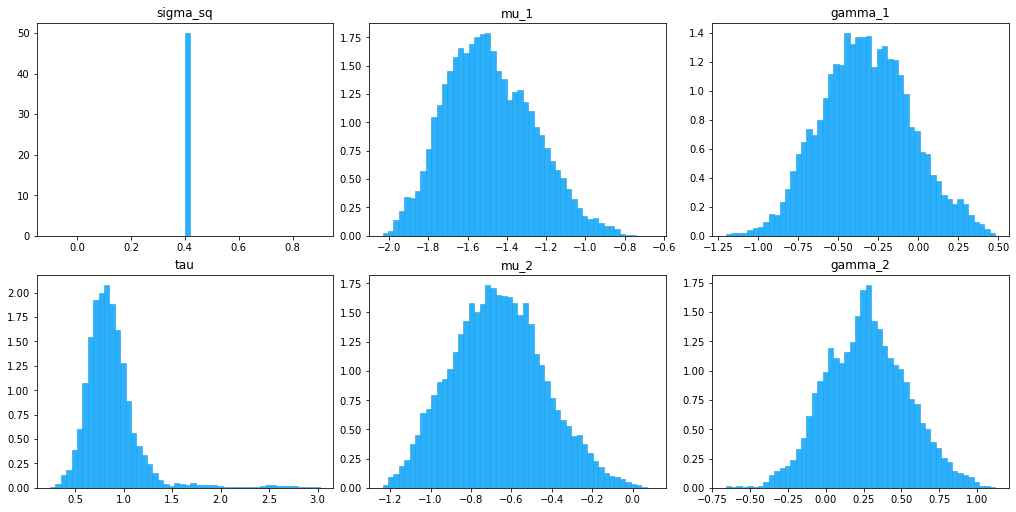


Using these estimates, we get the following:
The mean of group 1 is (-1.488, -0.666)
The mean of group 2 is (-0.325, 0.269)
The mean of group 3 is (-0.906, -0.199)
The mean of group 4 is (-1.335, -0.544)

For reference:
The actual mean of group 1 is (-1.403, -0.423)
The actual mean of group 2 is (-0.196, 0.471)
The actual mean of group 3 is (-0.919, -0.289)
The actual mean of group 4 is (-1.25, -0.594)

We also look at the correlation at lag 1 to see the Markov nature of the process.
The Pearson correlation for sigma_sq is nan
The Pearson correlation for tau is 0.999
The Pearson correlation for mu_1 is 0.999
The Pearson correlation for mu_2 is 0.999
The Pearson correlation for gamma_1 is 

/Users/aajeyajajoo/opt/miniconda3/envs/stats315a/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


0.999
The Pearson correlation for gamma_2 is 0.999


In [13]:
check_estimates(samples_hmc, data)

First thing to notice, the correlation values are pretty high for all the variables, as expected in a MCMC method.  Note that there is no correlation for $\sigma^2$ since we do not treat it as a parameter in HMC as mentioned above. The values of the means are pretty close to the actual values and are comparable to the estimates from MH. The correlation values are very high due to the small value of $\epsilon$. Since the step size is so small, the new sample generated is close to the old sample resulting in high correlation.

Another point worth noticing is that the algorithm is very sensitive to the value of $\epsilon$ and a small change can result in large deviations from the mean values. For our implementation, small values of $\epsilon$ seem to work best resulting in small changes in estimate values at every iteration. To check for sensitivity to $\epsilon$, we use hyperparameter tuning to find the best value. Our criterion to measure the best value is the efficiency of every run, since it results in the most number of samples generated.

### Hyperparameter Tuning

In [14]:
%%capture
effics = []
for e in np.arange(0.001, 0.04, 0.003):
    _, efficiency = HMC(initial, num_iters=int(1e4), epsilon=e);
    effics.append(efficiency)

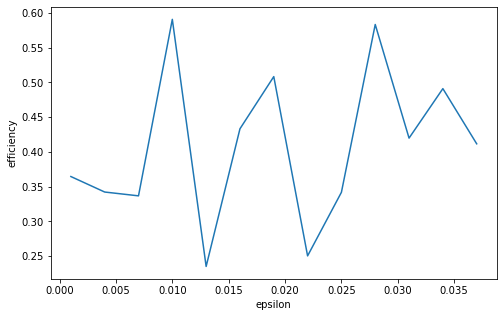

In [15]:
plt.plot(np.arange(0.001, 0.04, 0.003), effics);
plt.xlabel("epsilon")
plt.ylabel("efficiency")
fig = plt.gcf();
fig.set_size_inches((8,5));

We can see that the efficiency is highest around $\epsilon = 0.01$ and this is the value we pick to run our HMC algorithm.

Next, we move onto another MCMC method, Gibbs Sampling.

## 3. Gibbs Sampling

For Gibbs Sampling, we require the marginal distributions of every parameter assuming the other parameters are given. Using this, we can generate random draws from the marginals of the parameters turn by turn using the information of the previous draws when drawing from the later draws. Let's first derive the marginals for our parameters. We will perform a blocked version of Gibbs Sampling where we will treat $\mu_1$ and $\mu_2$ as one parameter $\mu$, and the same goes for $\gamma$. Hence, in total we have four parameters - $\sigma^2, \tau, \mu$ and $\gamma$.

To derive the marginals, we use the trick that the marginals are simply proportional to the posterior density with the relevant terms being only those that contain the parameter we are finding the marginal for (as suggested in [this](https://www.youtube.com/watch?v=9e4uqODjooo&t=449s) excellent video).

(Note: in each of these derivations, the $\nu_i$ term stands for the mean of the distribution of samples coming from group $i$, so, for example, $y_k - \nu_i$ for a sample $k$ coming from group $2$ would have $\nu_i =\gamma$. Also, with a bit of abuse of notation, whenever a summation appears over any group i.e. with index $i$, the sum is assumed to be over all elements $k$ in the group. So, for example, $\sum_{i=1}y_k$ means the sum of $y$ values for all entries from group $1$.)


The marginal for $\sigma^2$ is
$$
\begin{aligned}
& p\left(\sigma^2 \mid y, \theta[-\sigma^2\right]) \propto \frac{1}{\sigma^2}\prod_{i=1} N\left(\mu, \sigma^2 I\right) \cdot \prod_{i=2} N\left(\gamma, \sigma^2 I\right) \cdot \prod_{i=3} N\left(0.5 \mu+0.5 \gamma, \sigma^2 I\right) \cdot \prod_{i=4} N\left(\tau \mu+(1-\tau) \gamma, \sigma^2 I\right) \\
& \propto\left|\sigma^2 I\right|^{-n / 2} \cdot \frac{1}{\sigma^2} \cdot \exp \left(-\frac{1}{2 \sigma^2} \sum_{k=1}^n (y_k - \nu_i)^{T} I^{-1} (y_k - \nu_i)\right) \\
& \propto\left(\frac{1}{\sigma^2}\right)^{n+1} \cdot \exp \left(-\frac{1}{\sigma^2} \cdot \frac{1}{2} \sum_{k=1}^n ||y_k - \nu_i||^2\right) \\
& \text{which is of the form }x^{-\alpha-1} \cdot e^{ \frac{-\beta}{x}} \text{ which is an inverse gamma distribution}\\
& \therefore \sigma^2 \mid y, \theta\left[-\sigma^2\right] \sim \operatorname{InvGamma}(n,\frac{1}{2}\sum_{k=1}^n||y_k - \nu_i||^2) \\
&
\end{aligned}
$$
where $i$ is the group sample $k$ belongs to. We now write a function to find the parameters for the input of the inverse-gamma density.

In [8]:
def calc_params_sig_sq(theta, y=data):
    
    sig_sq, tau, mu1, mu2, gam1, gam2 = theta
    y1, y2, group = y['X1'], y['X2'], y['group']
    n1, n2, n3, n4 = len(group[group==1]), len(group[group==2]), len(group[group==3]), len(group[group==4])
    num_obs = len(group)
    
    params = [0, 0]
    params[0] = num_obs
    
    for i in range(num_obs):
        
        if group[i] == 1:
            params[1] += (y1[i]-mu1)**2 + (y2[i]-mu2)**2
            
        if group[i] == 2:
            params[1] += (y1[i]-gam1)**2 + (y2[i]-gam2)**2
            
        if group[i] == 3:
            params[1] += (y1[i]-(0.5*mu1 + 0.5*gam1))**2 + (y2[i]-(0.5*mu2 + 0.5*gam2))**2
            
        if group[i] == 4:
            params[1] += (y1[i]-(tau*mu1 + (1-tau)*gam1))**2 + (y2[i]-(tau*mu2 + (1-tau)*gam2))**2
            
    params[1] /= 2
    
    return params

The maginal for $\tau$ is (note that $\tau$ is only in group $4$)

$$
\begin{aligned}
p(\tau \mid y, \theta[-\tau]) & \propto \exp \left(-\frac{1}{2 \sigma^2} \sum_{i=4}\left(y_k-(\tau \mu+(1-\tau) \gamma)\right)^T I^{-1}\left(y_k-(\tau \mu+(1-\tau) \gamma)\right)\right) \\
& \propto \exp \left(-\frac{1}{2} \cdot \frac{\|\gamma-\mu\|_2^2}{\sigma^2} \sum_{i=4}\left(\tau -\alpha_k\right)^{T}\left(\tau -\alpha_k\right)\right) \\
& \alpha \exp \left(-\frac{1}{2} \cdot \frac{n_4\|\gamma-\mu\|_2^2}{\sigma^2}\left(\tau-\frac{\sum_{i=4} \alpha_k}{n_4}\right)^2\right)
\end{aligned}
$$
So, 
$$
\tau \mid y, \theta[-\tau] \sim \text { TruncNormal }\left(\frac{\sum_{i=4} \alpha_k}{n_4}, \frac{\sigma^2}{n_4\|\gamma-\mu\|_2^2}, 0,1\right)
$$

where $\alpha_k=y_k^T \mu-\gamma^T \gamma-y_k^T \gamma-\mu^T \gamma$. We now write a function to find the parameters of this truncated normal.

In [9]:
def calc_params_tau(theta, y=data):
    
    sig_sq, tau, mu1, mu2, gam1, gam2 = theta
    y1, y2, group = y['X1'], y['X2'], y['group']
    n1, n2, n3, n4 = len(group[group==1]), len(group[group==2]), len(group[group==3]), len(group[group==4])
    num_obs = len(group)
        
    params = [0, 0]
    params[1] = sig_sq / (n4*((gam1-mu1)**2 + (gam2-mu2)**2))
    
    mu = np.asarray([mu1, mu2])
    gamma = np.asarray([gam1, gam2])
    
    for i in range(num_obs):
        
        if group[i] == 4:
            yk = np.asarray([y1[i], y2[i]])
            params[0] += yk@mu - gamma@gamma - yk@gamma - mu@gamma
#             params[0] += yk@mu - yk@gamma - mu@gamma
            
    params[0] /= n4
    
    return params

The marginal for $\mu$ is 

$$
\begin{aligned}
& p(\mu\mid y, \theta[-\mu]) \propto \exp \left(-\frac{1}{2 \sigma^2} \sum_{i \in\{1, 3, 4\}}\left(y_k-\nu_i\right)^T I^{-1}\left(y_k-\nu_i\right)\right) \\
& \propto \exp \left(-\frac{1}{2} \cdot \frac{1}{\sigma^2} \sum_{i \in\{1,3, 4\}}\left(\mu-\alpha_k\right)^T I^{-1}\left(\mu-\alpha_k\right)\right) \\
& \propto \exp \left(-\frac{1}{2} \cdot \frac{1}{\sigma^2} \sum_{i \in\{1,3, 4\}}\left(\|\mu\|^2-2 \mu^T \alpha_k+\left\|\alpha_k\right\|^2\right)\right) \\
&\text{(next, we use the usual complete-the-square trick for all three relevant groups to get)}\\
& \therefore \mu \mid y, \theta[-\mu] \sim \operatorname{Normal}\left(\frac{\sum_{i \in\{1,3,4\}} \alpha_k}{n_1+0.5^2 n_3+\tau^2 n_4}, \frac{\sigma^2}{n_1+0.5^2 n_3+\tau^2 n_4}I\right) \\
&
\end{aligned}
$$
where  $\alpha_1=y_k ; \quad \alpha_3=\left(y_k-0.5 \gamma\right)*0.5 ; \quad \alpha_4=\left(y_k-(1-\tau) \gamma\right) * \tau$. We now write a function to find the parameters of this normal.

In [10]:
def calc_params_mu(theta, y=data):
    
    sig_sq, tau, mu1, mu2, gam1, gam2 = theta
    y1, y2, group = y['X1'].astype('float64'), y['X2'].astype('float64'), y['group']
    n1, n2, n3, n4 = len(group[group==1]), len(group[group==2]), len(group[group==3]), len(group[group==4])
    num_obs = len(group)
    
    params = [np.asarray([0., 0.]), np.eye(2)]
    params[1] = (sig_sq / (n1 + 0.5*0.5*n3 + (tau**2)*n4))*np.eye(2)
    
    mu = np.asarray([mu1, mu2]).astype('float64')
    gamma = np.asarray([gam1, gam2]).astype('float64')
    
    for i in range(num_obs):
        
        if group[i] == 1:
            params[0] += (np.asarray([y1[i], y2[i]]))
            
        if group[i] == 3:
            params[0] += ((0.5))*(np.asarray([y1[i],y2[i]])-0.5*gamma)
            
        if group[i] == 4:
            params[0] += ((tau))*(np.asarray([y1[i],y2[i]])-((1-tau)*gamma))
            
    params[0] /= (n1 + 0.5*0.5*n3 + (tau**2)*n4)
    
    return params

The marginal for $\gamma$ is very similar to $\mu$ and we can directly write it as 

$$
\begin{aligned}
\gamma \mid y, \theta[-\gamma] \sim \operatorname{Normal}\left(\frac{\sum_{i \in\{2,3,4\}} \alpha_k}{n_2+0.5^2 n_3+(1-\tau)^2 n_4}, \frac{\sigma^2}{n_2+0.5^2 n_3+(1-\tau)^2 n_4}I\right) \\
&
\end{aligned}
$$
where  $\alpha_2=y_k ; \quad \alpha_3=\left(y_k-0.5 \mu\right) * 0.5 ; \quad \alpha_4=\left(y_k-\tau \mu\right) * (1-\tau)$. We now write a function to find the parameters of this normal.

In [11]:
def calc_params_gamma(theta, y=data):
    
    sig_sq, tau, mu1, mu2, gam1, gam2 = theta
    y1, y2, group = y['X1'].astype('float64'), y['X2'].astype('float64'), y['group']
    n1, n2, n3, n4 = len(group[group==1]), len(group[group==2]), len(group[group==3]), len(group[group==4])
    num_obs = len(group)
    
    params = [np.asarray([0., 0.]), np.eye(2)]
    params[1] = (sig_sq / (n2 + 0.5*0.5*n3 + ((1-tau)**2)*n4))*np.eye(2)
    
    mu = np.asarray([mu1, mu2])
    gamma = np.asarray([gam1, gam2])
    
    for i in range(num_obs):
        
        if group[i] == 2:
            params[0] += (np.asarray([y1[i], y2[i]]))
            
        if group[i] == 3:
            params[0] += ((0.5))*(np.asarray([y1[i],y2[i]])-0.5*mu)
            
        if group[i] == 4:
            params[0] += (((1-tau)))*(np.asarray([y1[i],y2[i]])-(tau*mu))
            
    params[0] /= (n2 + 0.5*0.5*n3 + ((1-tau)**2)*n4)
    
    return params

We are now ready to write our Gibbs Sampling routine.

Note: since numpy uses the shape and scale parameterization of the gamma distribution, we use the following fact to sample from an inverse gamma: 
$$
\text { If } X \sim \operatorname{Gamma}(k, \theta) \text {, where } \theta \text { is the scale parameter, then } 1 / X \sim I G(k, 1 / \theta) \text {. }
$$

In [12]:
def gibbs_sampling(initial, num_iters):
    
    samples = [initial]
    
    for i in tqdm(range(num_iters)):
        temp = samples[-1].copy()
        
        params = calc_params_sig_sq(temp.copy())
        recip_sig_sq = np.random.gamma(params[0], 1./params[1])
        sig_sq = 1./recip_sig_sq
        temp[0] = sig_sq
        
        params = calc_params_tau(temp.copy())
        myclip_a = 0
        myclip_b = 1
        my_mean = params[0]
        my_std = np.sqrt(params[1])
        a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
        X = stats.truncnorm(a, b, loc=my_mean, scale=my_std) # define the truncated normal variable
        temp[1] = X.rvs()
        
        params = calc_params_mu(temp.copy())
        mu = np.random.multivariate_normal(params[0], params[1])
        temp[2], temp[3] = mu[0], mu[1]
        
        params = calc_params_gamma(temp.copy())
        gamma = np.random.multivariate_normal(params[0], params[1])
        temp[4], temp[5] = gamma[0], gamma[1]
        
        samples.append(temp)
        
    return samples

Let's run Gibbs Sampling on our data and check the estimates.

In [13]:
np.random.seed(2)

num_iters = int(1e5)
burn_in = num_iters//100
initial = [0.4, 0.5, 0., -0.5, 0., 0.5]
samples_gs = gibbs_sampling(initial, num_iters);
samples_gs = samples_gs[burn_in:]
samples_gs = [np.asarray(i, dtype = 'float64') for i in samples_gs]

100%|██████████████████████████████████| 100000/100000 [04:57<00:00, 335.81it/s]


The mean estimate for sigma_sq is 0.163
The mean estimate for tau is 0.7
The mean estimate for mu_1 is -1.359
The mean estimate for mu_2 is -0.574
The mean estimate for gamma_1 is -0.435
The mean estimate for gamma_2 is 0.174


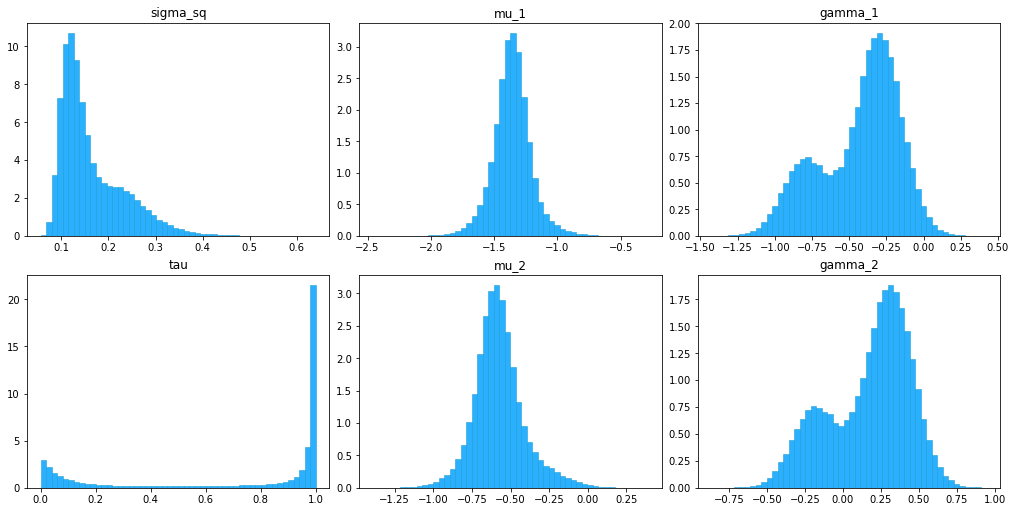


Using these estimates, we get the following:
The mean of group 1 is (-1.359, -0.574)
The mean of group 2 is (-0.435, 0.174)
The mean of group 3 is (-0.897, -0.2)
The mean of group 4 is (-1.081, -0.35)

For reference:
The actual mean of group 1 is (-1.403, -0.423)
The actual mean of group 2 is (-0.196, 0.471)
The actual mean of group 3 is (-0.919, -0.289)
The actual mean of group 4 is (-1.25, -0.594)

We also look at the correlation at lag 1 to see the Markov nature of the process.
The Pearson correlation for sigma_sq is 0.637
The Pearson correlation for tau is 0.863
The Pearson correlation for mu_1 is 0.029
The Pearson correlation for mu_2 is 0.201
The Pearson correlation for gamma_1 is 0.711
The Pearson correlation for gamma_2 is 0.67


In [14]:
check_estimates(samples_gs)

Firstly, the correlation values for the Gibbs routine is generally high (due to the Markov nature) but not as high as the other MCMC methods. This reflects the fact that a random draw is taken for every parameter at every iteration, which might not be correlated to the previous draw. However we do expect some correlation since the new draws for the parameters are used at every iteration when calculating the marginals for the remaining parameters.

Also, the statistic values using Gibbs Sampling are once again decent and comparable to the other MCMC methods we have seen so far.

Finally, we move to Importance Sampling.

## 4. Importance Sampling (via Rejection Sampling)

For rejection sampling, we need to pick a proposal distribution and then scale it to a value above our target distribution (the posterior in our case). We pick normal distributions centered at the mean of the posterior (up to a constant). Since we do not know anything about the shape of the posterior, a good place to start is the mean of the data since the mass is likely to be of higher concentration there, which will result in higher efficiency (more acceptance) of our algorithm. This is done for $\mu$ and $\gamma$. The stddev of all of these is kept the same at 0.4. We can vary this later to find the best jump parameter.

As for $\sigma^2$, all we know is that it always needs to be positive. For this, we use the scaled (divide by 10) $\chi^2$ distribution with 3 degrees of freedom since it's peak is closest to the value of $\sigma^2$ estimated by MH.

For $\tau$, we use the truncated normal instead of the actual normal to ensure that the values are constrained between 0 and 1. The mean is kept at 0.8 since using this value takes us closest to the mean of the data. Accordingly, the variance is also reduced to ensure that we do not keep going out of bounds.

So we use the following proposals (keeping in mind that since we're modelling the parameters as independent, the final proposal $g$ is a product of all of these):
1. $\sigma^2: \frac{\chi^2_{(3)}}{10}$ 
2. $\tau: N(0.80, 0.04)$ truncated between 0 and 1.
3. $\mu_1: N(-1.40, 0.16)$
4. $\mu_2: N(-0.42, 0.16)$
5. $\gamma_1: N(-0.19, 0.16)$
6. $\gamma_2: N(0.47, 0.16)$

Note that we have to raise $g$ to the number of data points since the likelihood is compounded over the same number of data points. If we don't do this, our numerator in the acceptance probability will be way lower than the denominator and we will never accept any sample.

The scaling factor is another hyperparameter we need to choose. Since we have given some thought into picking the proposal distributions and ensured that the peaks are where they need to be, we do not need our scaling factor to be very high. We start with a value of 50 since it should ensure that the posterior is always contained inside the scaled proposal distribution, while also not being so high as to result is a very poor efficiency.

In [8]:
np.random.seed(2)

def rejection(num_iters, M):
    
    samples = []
    
    for _ in tqdm(range(num_iters)):
        
        sig_sq_c = np.random.chisquare(df=3)/10
        a, b = (0-0.8)/0.2, (1-0.8)/0.2
        X = stats.truncnorm(a, b, 0.8, 0.2) # define the truncated normal variable
        tau_c = X.rvs(1)[0]
        mu1_c, mu2_c = np.random.normal(-1.40, 0.4), np.random.normal(-0.42, 0.4)
        gam1_c, gam2_c = np.random.normal(-0.19, 0.4), np.random.normal(0.47, 0.4)
        
        candidate = [sig_sq_c, tau_c, mu1_c, mu2_c, gam1_c, gam2_c]
        
        g_cand = chi2.pdf(sig_sq_c, 3)*norm(0.8, 0.2).pdf(tau_c)*norm(-1.4, 0.4).pdf(mu1_c)
        g_cand *= norm(-0.42, 0.4).pdf(mu2_c)*norm(-0.19, 0.4).pdf(gam1_c)*norm(0.47, 0.4).pdf(gam2_c)
        g_cand = g_cand**24 # raise g to number of data points
        
        accept_prob = calc_posterior(candidate) / (M*g_cand)
        
        if np.random.random() < accept_prob:
            samples.append(candidate)
            
    return samples

Let's run Rejection Sampling on our data and check the results.

In [9]:
num_iters = int(1e5)
M = 50

samples_rs = rejection(num_iters, M)

100%|██████████████████████████████████| 100000/100000 [09:51<00:00, 169.16it/s]


The mean estimate for sigma_sq is 0.304
The mean estimate for tau is 0.74
The mean estimate for mu_1 is -1.407
The mean estimate for mu_2 is -0.436
The mean estimate for gamma_1 is -0.196
The mean estimate for gamma_2 is 0.46


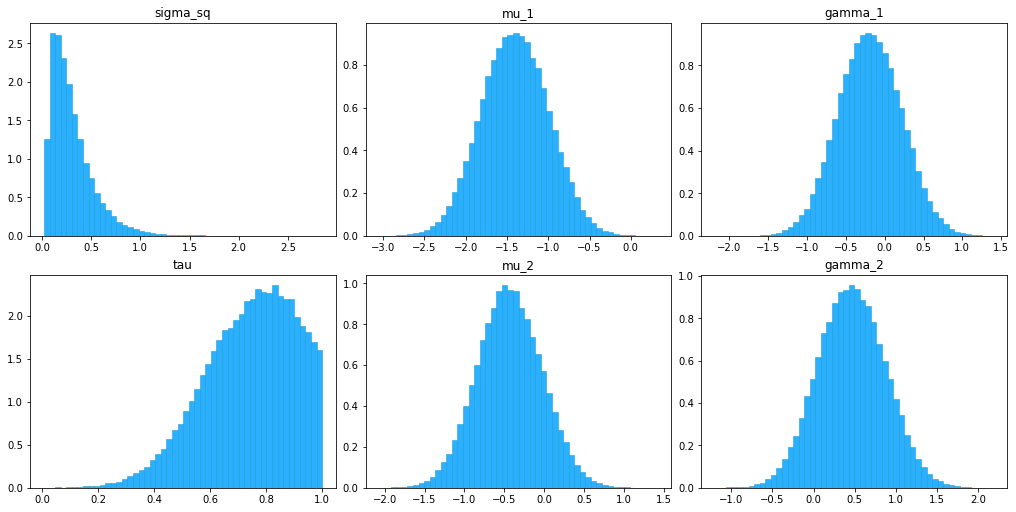


Using these estimates, we get the following:
The mean of group 1 is (-1.407, -0.436)
The mean of group 2 is (-0.196, 0.46)
The mean of group 3 is (-0.801, 0.012)
The mean of group 4 is (-1.092, -0.203)

For reference:
The actual mean of group 1 is (-1.403, -0.423)
The actual mean of group 2 is (-0.196, 0.471)
The actual mean of group 3 is (-0.919, -0.289)
The actual mean of group 4 is (-1.25, -0.594)

We also look at the correlation at lag 1 to see the Markov nature of the process.
The Pearson correlation for sigma_sq is -0.004
The Pearson correlation for tau is 0.005
The Pearson correlation for mu_1 is 0.001
The Pearson correlation for mu_2 is 0.004
The Pearson correlation for gamma_1 is 0.002
The Pearson correlation for gamma_2 is 0.004


In [10]:
check_estimates(samples_rs, data)

We see here that the estimates perform really well. This is mostly because our choice of the proposal distribution was highly tailored and used information we obtained from the MH algorithm. If we were to randomly start the RS algorithm using information just from the priors, we should expect to see poorer performance. 

</br>
Another thing worth noticing is that the correaltion values are really low, as expected. The RS algorithm is not an MCMC algorithm and hence does not rely on the Markov property, which is confirmed by the values.
</br>
</br>
Now that we have the samples from rejection sampling, we can use importance sampling to find the mean instead of computing it directly from the samples. We will calculate the mean of the parameters using importance sampling.
$$
E[f(x)]=\int f(x) p(x) d x=\int f(x) \frac{p(x)}{q(x)} q(x) d x \approx \frac{1}{n} \sum_i f\left(x_i\right) \frac{p\left(x_i\right)}{q\left(x_i\right)}
$$
Here we notice that sampling from $p$ directly is difficult. So instead, we sample from $q$ and use the ratio of the densities to estimate the desired moment. If we are trying to estimate $E[\tau]$ for example, the importance distribution $q$ could be set to the uniform prior. The process is similar for $\mu$ and $\gamma$, with the bounds of uniform changed. For $\tau$, we use $[0,1]$, while for $\mu$ we use $[-2, -1] \times [-1, 0]$ and for $\gamma$ we use $[-1, 0] \times [0, 1]$.
</br>
</br>
To start the process, we need to fit a kernel density to our list of samples generated using RS to get values for $p$. Next we fit them and calculate the means using the uniform importance distribution.

In [11]:
def importance_sampling(samples, num_obs):

    means = []
    bounds = [(0,1), (-2, -1), (-1, 0), (-1, 0), (0, 1)]

    for i in tqdm(range(5)):

        estimates = [sample[i+1] for sample in samples]
        kde = sm.nonparametric.KDEUnivariate(estimates)
        kde.fit()
        mean = 0
        
        for _ in range(num_obs):
            
            uni = np.random.uniform(low=bounds[i][0], high=bounds[i][1]) # generate sample from importance dist.
            mean += uni*(kde.evaluate(uni))
            
        means.append(mean/num_obs)
        
    return means

Let's run Importance Sampling on our data and check the results.

In [12]:
num_obs = int(1e5)

means_is = importance_sampling(samples_rs, num_obs)
means_g4_1 = means_is[0][0]*means_is[1][0]+(1-means_is[0][0])*means_is[3][0]
means_g4_2 = means_is[0][0]*means_is[2][0]+(1-means_is[0][0])*means_is[4][0]

print("\nUsing these estimates, we get the following:")
print("The mean of group 1 is ({}, {})".format(round(means_is[1][0], 3), round(means_is[2][0], 3)))
print("The mean of group 2 is ({}, {})".format(round(means_is[3][0], 3), round(means_is[4][0], 3)))
print("The mean of group 4 is ({}, {})".format(round(means_g4_1, 3), round(means_g4_2, 3)))

actual_estimates()

100%|█████████████████████████████████████████████| 5/5 [03:50<00:00, 46.20s/it]


Using these estimates, we get the following:
The mean of group 1 is (-1.121, -0.37)
The mean of group 2 is (-0.253, 0.371)
The mean of group 4 is (-0.886, -0.169)

For reference:
The actual mean of group 1 is (-1.403, -0.423)
The actual mean of group 2 is (-0.196, 0.471)
The actual mean of group 3 is (-0.919, -0.289)
The actual mean of group 4 is (-1.25, -0.594)


We see that importance sampling does not work as well as the MH algorithm. This might be due to the fact that we first perform rejection sampling to sample from the target distribution and then perform importance sampling on it to get the mean. This two layered process results in increased stochastic-ness of the entire algorithm leading to below par estimates.

## 5. Summary

In conclusion, HMC with a small step-size as well as Gibbs Sampling perform well. This is expected since they are known to do well in higher dimension sampling. MH also works well but is limited due to it's tendency to get stuck at a point for high dimensions. Importance Sampling is tricky cause it is not really a sampling method. It is used to derive statistics for unknown distributions. We used Rejection Sampling in lieu of it which worked really well. 

As for scalability, we should expect MH to scale well with more data, but not so well if the number of parameters in the model are increased. On the other hand, Gibbs and HMC will work well with even more dimensions but due to the involvement of gradients and marginals, can be expected to run slower and require much more computational power once the size of the dataset increases. Rejection sampling is pretty straight-forward and can work well with more data and more parameters. 